# ASL Alphabet Classification


## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Data Loading and Preprocessing

In [2]:
train_path = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_path = '/kaggle/input/asl-alphabet/asl_alphabet_test'
thresh = 1000

In [3]:
train_img_names = os.listdir(train_path)
train_img_names = sorted(train_img_names)
train_imgs = []
for cat in tqdm(train_img_names[:]):
    for img in tqdm(os.listdir(train_path + '/' + cat)[:thresh]):
        train_imgs.append(img)
# print(train_imgs)

100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


In [4]:
print(len(train_imgs))

29000


In [5]:
train_images = []
train_labels = []
for img in tqdm(train_imgs):
    if img[0].isupper():
        train_labels.append(img[0])
        img = cv2.imread(f'{train_path}/{img[0]}/{img}')
    elif img[0:3] == 'del':
        img = cv2.imread(f'{train_path}/{img[0:3]}/{img}')
        train_labels.append('del')
    elif img[0:5] == 'space':
        img = cv2.imread(f'{train_path}/{img[0:5]}/{img}')
        train_labels.append('space')
    elif img[0:7] == 'nothing':
        img = cv2.imread(f'{train_path}/{img[0:7]}/{img}')
        train_labels.append('nothing')
    train_images.append(img)

100%|██████████| 29000/29000 [03:08<00:00, 153.82it/s]


In [6]:
print(train_images[0].shape)

(200, 200, 3)


In [7]:
from skimage.transform import resize
size = 64
train_images_reshaped = []
for img in tqdm(train_images[:]):
    img = resize(img, (64, 64, 3))
    train_images_reshaped.append(img)
    
# Converting into numpy as it is important for keras to have data into numpy array form
train_images_reshaped = np.array(train_images_reshaped)

100%|██████████| 29000/29000 [01:28<00:00, 327.93it/s]


In [8]:
del train_images
del train_imgs
del train_img_names

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
train_labels

array([ 0,  0,  0, ..., 28, 28, 28])

In [10]:
train_split = 0.8
train_split_len = int(train_split*train_images_reshaped.shape[0])
print('Train Split Length', train_split_len)
train_idxs = np.random.choice(len(train_labels), size=train_split_len, replace=False)
print(train_idxs)
valid_idxs = []
# valid_idxs = np.setdiff1d(range(len(train_labels)), train_idxs)
for g in range(len(train_labels)):
    if g not in train_idxs:
        valid_idxs.append(g)
print('U bastard', len(valid_idxs))

# Train Images and Labels
train_images_m = train_images_reshaped[train_idxs]
train_labels_m = train_labels[train_idxs]

# Validation Images and Labels
valid_images_m = train_images_reshaped[valid_idxs]
valid_labels_m = train_labels[valid_idxs]

print(train_labels.shape)
print(train_labels_m.shape)
print(valid_labels_m.shape)

Train Split Length 23200
[21206 22064  9269 ... 16345  5179 28191]
U bastard 5800
(29000,)
(23200,)
(5800,)


In [11]:
del train_images_reshaped

## Modelling

In [12]:
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [13]:
from keras.callbacks import EarlyStopping
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(train_images_m, train_labels_m, validation_data=(valid_images_m, valid_labels_m), epochs=100, callbacks=[early_stopping])

Epoch 1/100
725/725 [==============================] - 17s 11ms/step - loss: 1.6975 - accuracy: 0.4947 - val_loss: 0.5969 - val_accuracy: 0.8069
Epoch 2/100
725/725 [==============================] - 8s 11ms/step - loss: 0.3350 - accuracy: 0.8885 - val_loss: 0.3177 - val_accuracy: 0.9221
Epoch 3/100
725/725 [==============================] - 8s 10ms/step - loss: 0.1502 - accuracy: 0.9493 - val_loss: 0.2394 - val_accuracy: 0.9486
Epoch 4/100
725/725 [==============================] - 8s 11ms/step - loss: 0.1040 - accuracy: 0.9681 - val_loss: 0.2385 - val_accuracy: 0.9524
Epoch 5/100
725/725 [==============================] - 8s 11ms/step - loss: 0.0740 - accuracy: 0.9766 - val_loss: 0.2177 - val_accuracy: 0.9712
Epoch 6/100
725/725 [==============================] - 8s 10ms/step - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.3140 - val_accuracy: 0.9788
Epoch 7/100
725/725 [==============================] - 8s 11ms/step - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.3859 - val_accuracy

## Evaluation

In [14]:
from sklearn.metrics import accuracy_score
test_thresh = len(valid_labels_m)
valid_label_preds = []
for _, i in (enumerate(valid_images_m[:test_thresh])):
    prediction = model.predict(i.reshape((1, 64, 64, 3)), verbose=0).argmax()
    valid_label_preds.append(prediction)
    print(valid_labels_m[_], prediction)
    
accuracy_score(valid_labels_m[:test_thresh], valid_label_preds)

0 14
0 25
0 25
0 25
0 25
0 25
0 25
0 25
0 25
0 18
0 14
0 14
0 14
0 18
0 14
0 25
0 25
0 25
0 27
0 14
0 25
0 25
0 25
0 25
0 25
0 3
0 25
0 25
0 27
0 25
0 25
0 14
0 14
0 14
0 14
0 14
0 14
0 25
0 14
0 25
0 14
0 25
0 14
0 14
0 25
0 25
0 14
0 25
0 18
0 25
0 14
0 18
0 18
0 14
0 14
0 25
0 25
0 25
0 25
0 14
0 25
0 14
0 18
0 25
0 14
0 14
0 25
0 25
0 25
0 3
0 14
0 14
0 25
0 25
0 25
0 27
0 25
0 25
0 14
0 3
0 18
0 14
0 14
0 25
0 27
0 14
0 25
0 25
0 14
0 14
0 27
0 14
0 14
0 14
0 25
0 27
0 25
0 14
0 18
0 25
0 25
0 25
0 25
0 25
0 27
0 25
0 25
0 14
0 25
0 14
0 25
0 0
0 18
0 27
0 14
0 14
0 18
0 18
0 14
0 14
0 18
0 25
0 14
0 25
0 25
0 14
0 25
0 25
0 25
0 14
0 0
0 25
0 14
0 18
0 18
0 14
0 25
0 25
0 25
0 25
0 25
0 25
0 14
0 18
0 14
0 14
0 14
0 25
0 25
0 14
0 25
0 25
0 1
0 27
0 25
0 25
0 18
0 25
0 25
0 25
0 25
0 25
0 18
0 18
0 14
0 14
0 25
0 3
0 14
0 25
0 14
0 27
0 14
0 14
0 25
0 25
0 25
0 18
0 25
0 25
0 25
0 18
0 25
0 27
0 14
0 14
0 14
1 14
1 14
1 27
1 18
1 14
1 14
1 25
1 14
1 27
1 14
1 14
1 25
1 14
1 27
1 

0.11206896551724138

# Conclusion:
We have used a simple Deep Fully Connected CNN based Neural Network to classify ASL Alphabet images into their respective alphabetic representations.\
This approach has obtained us the overall accuracy of 

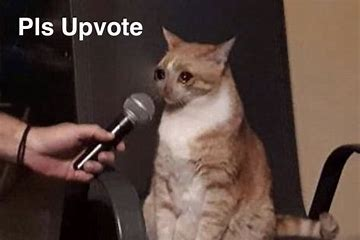